<font size="+3"><strong>Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components</strong></font>

# Prepare Data

## Import 

In [ ]:
# # used to change filepaths
# import os

# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from IPython.display import display
# %matplotlib inline

# import pandas as pd
# import numpy as np

# from PIL import Image

# from skimage.feature import hog
# from skimage.color import rgb2gray

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# from sklearn.model_selection import train_test_split

# from sklearn.svm import SVC

# from sklearn.metrics import roc_curve, auc, accuracy_score

In [1]:
# Importing necessary libraries 

import tensorflow as tf
# assert tf.__version__.startswith('2')

from google.colab import files # For downloading Files
from google.colab import drive # For Mounting Google drive
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Moving to the necessary folder

%cd drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset

/content/drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset


In [4]:
%ls -la

total 13547
drwx------ 2 root root     4096 May  9 18:45 Capacitor/
-rw------- 1 root root      112 Jun  9 07:25 labels.txt
-rw------- 1 root root 13846248 Jun  6 21:03 mobilenet_v2_naive_model.tflite
drwx------ 2 root root     4096 Jun  9 11:08 path/
drwx------ 2 root root     4096 May  9 18:45 Resistor/
drwx------ 2 root root     4096 Jun  6 03:09 save/
drwx------ 2 root root     4096 May  9 18:45 Transistor/
drwx------ 2 root root     4096 May  9 18:45 upload/


## Explore

## Split

In [5]:
# Setting the base directory and defines constants for the data generator and model training

base_dir = 'upload'
base_dir = pathlib.Path(base_dir)
VALIDATION_SPLIT = 0.3
SEED = 100
BATCH_SIZE = 128
IMAGE_SIZE = 224
# IMAGE_SIZE = 128
base_learning_rate = 0.00001

In [6]:
# Creating the Image data generator with data augmentation

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    seed=SEED,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    seed=SEED,
    subset='validation')

Found 23569 images belonging to 11 classes.
Found 10096 images belonging to 11 classes.


In [9]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((128, 224, 224, 3), (128, 11))

In [10]:
# Generator is used to retrieve batch of images and labels for training

print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'Batteries': 0, 'Capacitor': 1, 'Cartridge_fuse': 2, 'Circuit_breaker': 3, 'Filament_Bulb': 4, 'IC': 5, 'Inductor': 6, 'LED': 7, 'Resistor': 8, 'Transformer': 9, 'Transistor': 10}


In [11]:
!cat labels.txt

Batteries
Capacitor
Cartridge_fuse
Circuit_breaker
Filament_Bulb
IC
Inductor
LED
Resistor
Transformer
Transistor

# Build Model

## Baseline

In [12]:
# MobileNetV2 base model

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Experiementing with ResNet50
# base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
base_model.trainable = False

## Iterate and Evaluate

In [14]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(512, activation='relu'),  # Added a dense layer
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

In [15]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

In [16]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),  # Added batch normalization
    tf.keras.layers.Dropout(0.5),  # Increased dropout rate
    tf.keras.layers.Dense(512, activation='relu'),  # Added a dense layer
    tf.keras.layers.BatchNormalization(),  # Added batch normalization
    tf.keras.layers.Dropout(0.5),  # Increased dropout rate
    tf.keras.layers.Dense(11, activation='softmax')
])

In [17]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     base_model,
#     #tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

In [18]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
#     base_model,
#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(128, 3, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(256, 3, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                        

In [21]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 10


In [22]:
loss0, accuracy0 = model.evaluate(val_generator)

 9/79 [==>...........................] - ETA: 59:27 - loss: 2.3943 - accuracy: 0.1016  

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


79/79 [==============================] - 3808s 49s/step - loss: 2.4018 - accuracy: 0.0886


In [23]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    # min_delta=0,
    patience=3,
    verbose=1,
    mode='max')

# checkpoint_filepath = 'path/best_model'

# # Create a ModelCheckpoint callback to save the best model
# mcc = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )


In [24]:
# from tensorflow.keras.callbacks import Callback

# class ErrorHandlingCallback(Callback):
#     def __init__(self):
#         super(ErrorHandlingCallback, self).__init__()
#         self.best_weights = None
#         self.best_epoch = -1

#     def on_train_begin(self, logs=None):
#         self.best_weights = self.model.get_weights()

#     def on_epoch_end(self, epoch, logs=None):
#         if logs.get('loss') is None or logs.get('loss') == float('nan'):
#             print("Training error encountered. Restoring best weights from previous epoch.")
#             self.model.set_weights(self.best_weights)
#         else:
#             self.best_weights = self.model.get_weights()
#             self.best_epoch = epoch

#     def on_train_end(self, logs=None):
#         print("Training completed. Best epoch:", self.best_epoch)

# # Example usage
# model.fit(x_train, y_train, callbacks=[ErrorHandlingCallback(), early_stopping_callback, model_checkpoint_callback], ...)


In [25]:
initial_epochs = 5

In [26]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=initial_epochs, 
                    validation_data=val_generator,
                    callbacks=[es], 
                    validation_steps=len(val_generator))

Epoch 1/5
185/185 [==============================] - 9625s 52s/step - loss: 1.3276 - accuracy: 0.5930 - val_loss: 0.8572 - val_accuracy: 0.7251
Epoch 2/5
185/185 [==============================] - 2590s 14s/step - loss: 0.9547 - accuracy: 0.6913 - val_loss: 0.8438 - val_accuracy: 0.7394
Epoch 3/5
185/185 [==============================] - 2641s 14s/step - loss: 0.8544 - accuracy: 0.7238 - val_loss: 0.8271 - val_accuracy: 0.7526
Epoch 4/5
185/185 [==============================] - 2652s 14s/step - loss: 0.7955 - accuracy: 0.7423 - val_loss: 0.8235 - val_accuracy: 0.7584
Epoch 5/5
185/185 [==============================] - 2586s 14s/step - loss: 0.7613 - accuracy: 0.7549 - val_loss: 0.8278 - val_accuracy: 0.7549


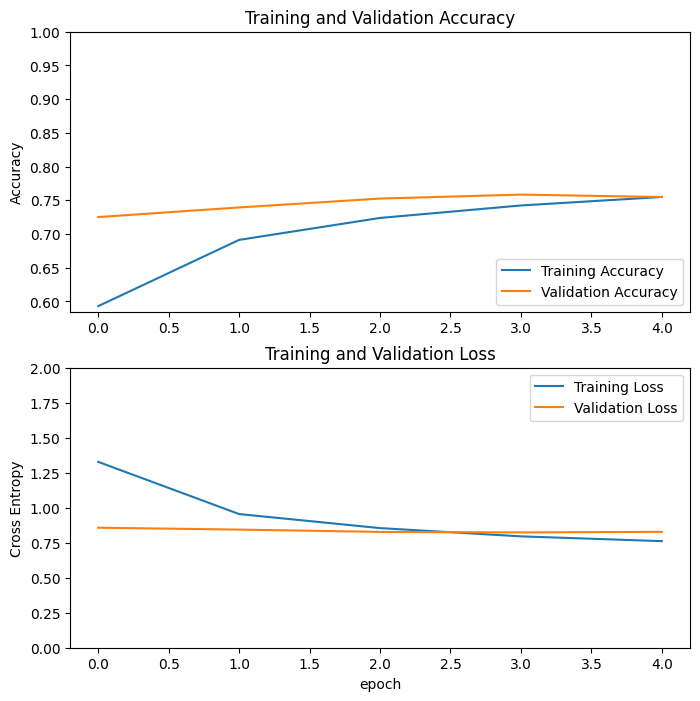

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# best_model = tf.keras.models.load_model(checkpoint_filepath)

In [ ]:
# epochs2 = 20
# total_epochs4 = total_epochs3 + epochs2 
# history3 = model.fit(train_generator, 
#                     steps_per_epoch=len(train_generator), 
#                     epochs= total_epochs4,
#                     initial_epoch=history2.epoch[-1],
#                     validation_data=val_generator, 
#                     validation_steps=len(val_generator))

In [ ]:
# acc = history3.history['accuracy']
# val_acc = history3.history['val_accuracy']



# loss = history3.history['loss']
# val_loss = history3.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,2.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [ ]:
# epochs1 = 20
# total_epochs3 = total_epochs2 + epochs1 
# history2 = model.fit(train_generator, 
#                     steps_per_epoch=len(train_generator), 
#                     epochs= total_epochs3,
#                     initial_epoch=history_fine2.epoch[-1],
#                     validation_data=val_generator, 
#                     validation_steps=len(val_generator))

In [ ]:
# acc = history2.history['accuracy']
# val_acc = history2.history['val_accuracy']



# loss = history2.history['loss']
# val_loss = history2.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,2.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

### Fine Tuning



In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [32]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [33]:
print(base_learning_rate)

1e-05


In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
#               metrics=['accuracy'])

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/100),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                        

In [36]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 64


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-d2bbea0c3005>", line 3, in <cell line: 3>
    history_fine = model.fit(train_generator,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:
OSError: [Errno 107] Transport endpoint is not connected: 'upload/Inductor/inductor_0993.jpeg'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_ren

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-a5904d64830d>", line 1, in <cell line: 1>
    acc = history_fine.history['accuracy']
NameError: name 'history_fine' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-p

In [ ]:
# fine_tune_epochs2 = 10
# total_epochs2 =  total_epochs + fine_tune_epochs
# history_fine2 = model.fit(train_generator, 
#                          steps_per_epoch=len(train_generator), 
#                          epochs=total_epochs2, 
#                          initial_epoch=history_fine.epoch[-1],
#                          validation_data=val_generator, 
#                          validation_steps=len(val_generator))

Epoch 20/30
 16/182 [=>............................] - ETA: 4:03 - loss: 0.5630 - accuracy: 0.8271

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


182/182 [==============================] - 448s 2s/step - loss: 0.5630 - accuracy: 0.8275 - val_loss: 4.0444 - val_accuracy: 0.3417
Epoch 21/30
182/182 [==============================] - 408s 2s/step - loss: 0.5129 - accuracy: 0.8451 - val_loss: 4.3187 - val_accuracy: 0.3967
Epoch 22/30
182/182 [==============================] - 409s 2s/step - loss: 0.4929 - accuracy: 0.8495 - val_loss: 4.1650 - val_accuracy: 0.3421
Epoch 23/30
182/182 [==============================] - 424s 2s/step - loss: 0.4649 - accuracy: 0.8574 - val_loss: 3.8981 - val_accuracy: 0.3529
Epoch 24/30
182/182 [==============================] - 422s 2s/step - loss: 0.4370 - accuracy: 0.8636 - val_loss: 4.8380 - val_accuracy: 0.3898
Epoch 25/30
182/182 [==============================] - 419s 2s/step - loss: 0.4334 - accuracy: 0.8672 - val_loss: 3.2751 - val_accuracy: 0.4336
Epoch 26/30
182/182 [==============================] - 398s 2s/step - loss: 0.4082 - accuracy: 0.8731 - val_loss: 3.3254 - val_accuracy: 0.4195
Epoc

# Communicate Results

## Saving Models

In [28]:
# Naive Model

saved_model_dir = 'save/naive_model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('mobilenet_v2_naive_11model.tflite', 'wb') as f:
    f.write(tflite_model)


In [29]:
files.download('mobilenet_v2_naive_11model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Fine Tuned Model

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('mobilenet_v2_fine_tuned.tflite', 'wb') as f:
    f.write(tflite_model)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-c1fded7580a0>", line 4, in <cell line: 4>
    tf.saved_model.save(model, saved_model_dir)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/save.py", line 1240, in save
    save_and_return_nodes(obj, export_dir, signatures, options)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/save.py", line 1283, in save_and_return_nodes
    path_helpers.get_or_create_variables_dir(export_dir)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/path_helpers.py", line 26, in get_or_create_variables_dir
    file_io.recursive_create_dir(variables_dir)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 498, in recursive_create_dir
    recursive_create_dir_v2(dirna

In [ ]:
files.download('mobilenet_v2_fine_tuned.tflite')
files.download('labels.txt')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-a88d1c12365c>", line 1, in <cell line: 1>
    files.download('mobilenet_v2_fine_tuned.tflite')
  File "/usr/local/lib/python3.10/dist-packages/google/colab/files.py", line 222, in download
    raise FileNotFoundError(msg)  # pylint: disable=undefined-variable
FileNotFoundError: Cannot find file: mobilenet_v2_fine_tuned.tflite

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr